In [1]:
%load_ext autoreload
%autoreload

import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../fit/")
import synthetic

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np


import analyze_synthetic
import utils

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/analysis/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

seed = 123
rng = np.random.default_rng(seed)
prng_state = jr.PRNGKey(seed)
batch_size = 10000

## Data

In [3]:
### data ###
data_path = "../../data/synthetic/"
session_name = "syn_data_seed123"
max_ISI_order = 4

select_fracs = [0.0, 1.0]

dataset_dict = synthetic.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

#covariates = dataset_dict['covariates']
#x_t, y_t = covariates['x'], covariates['y']


In [8]:
import matplotlib.pyplot as plt
plt.style.use(['../plots/paper.mplstyle'])

In [9]:
ts = 3000
dt = 0.001
p = 0.003
spikes_at = rng.binomial(1, p, size=(ts,))
spike_times = np.where(spikes_at > 0)[0]

time_t = np.arange(ts) * dt
rates_t = 30. * (np.sin(time_t * (1 + np.exp( -1.5 * (time_t - time_t[-1]/2.) ** 2 )))**2 + \
    np.exp( -0.5 * (time_t - time_t[-1]/3.) ** 2 ))


rtime_t = np.cumsum(rates_t * dt)
rspike_times = np.ceil(rtime_t[spike_times] / dt).astype(int)

In [13]:
tuning_dict['warp_tau']

array([  3.0087075,  60.18738  ,  42.552933 , 162.53026  ,   2.6303558,
         1.9249934,  42.967896 ,  37.357735 ,   8.848629 ], dtype=float32)

In [17]:
dataset_dict['ISIs'][:, 0, 0]

array([0.172, 0.173, 0.174, ..., 0.053, 0.054, 0.055])

In [60]:
model_name = 'syn_data_seed123ISI4sel0.0to1.0_PP-log_rcb-8-17.-36.-6.-30.-self-H500_factorized_gp-16-1000_' + \
    'X[x-y]_Z[]_freeze[obs_model0spikefilter0a-obs_model0spikefilter0log_c-obs_model0spikefilter0phi]'
model_name = 'syn_data_seed123ISI4sel0.0to1.0_PP-log_rcb-8-10.-20.-4.5-9.-self-H150_factorized_gp-16-1000_' + \
    'X[x-y]_Z[]_freeze[]'

checkpoint_dir = '../checkpoint/'#checkpoint_/'

# config
model, config = utils.load_model_and_config(
    checkpoint_dir + model_name, 
    dataset_dict, 
    synthetic.observed_kernel_dict_induc_list, 
    rng, 
)
obs_type = config.observations.split('-')[0]
jitter = config.jitter

In [61]:
filter_t, _ = model.obs_model.spikefilter.sample_posterior(
    prng_state, 1, False, None, jitter)
filter_t = np.array(filter_t[0])  # (filter_length, outs, 1)
prng_state, _ = jr.split(prng_state)

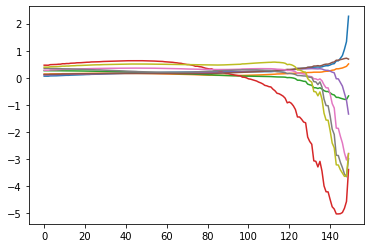

In [62]:
import matplotlib.pyplot as plt

plt.plot(filter_t[..., 0])
plt.show()

In [23]:
a, c = 4.5, 9.  # inverse width of the bumps, uniformity of the bump placement
phi_lower, phi_upper = 10., 20.
B = 8
filter_length = 150

obs_dims = 9
num_samps = 10

# RCB basis
a = a * np.ones((obs_dims, 1))
c = c * np.ones((obs_dims, 1))
phi_h = np.linspace(phi_lower, phi_upper, B)[:, None, None].repeat(obs_dims, axis=1)
w_h = np.array(model.obs_model.spikefilter.w)#np.zeros((B, obs_dims, 1))
#for o in range(obs_dims):
#    w_h[o, o, :] = 1.

flt = lib.filters.RaisedCosineBumps(
    a,
    c,
    w_h,
    phi_h,
    filter_length,
)

glm_basis = flt.sample_prior(prng_state, 1, None, jitter)
glm_basis = np.array(glm_basis[0])  # (filter_length, outs, 1)

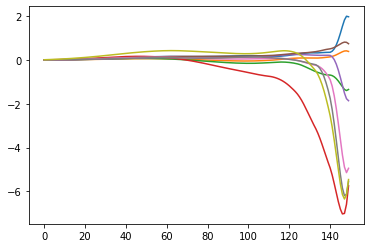

In [24]:
plt.plot(glm_basis[..., 0])
plt.show()

In [21]:
model.obs_model.spikefilter.phi.shape

(8, 9, 1)